#### Gradient Vanishing
 - During Backpropagation with deep Neural Net, teh derivations are getting too small
 - Due to Vanishing Gradient, your slope becomes too small and decreases gradually to a very small value

#### Gradient Exploding
 - The explosion occurs through exponential growth by repeatedly multiplying gradients through the network layers that have values larger than 1.0.
 - NaN valued weight values that can no longer be updated.

#### ==> Solutions
 - Change activation function
 - Careful initialization
 - Small learning rate
 - <span style="color:red"><strong>Batch Normalization</strong></span>
   - BatchNormalization allows us to use much higher learning rate & to be less careful to parameter initialization
   - even in some cases, eliminate the needs for Dropout ==> work as kinda regularizer which prevents overfitting

![img](./Covariatvie_shift.png)

### Internal Covariate Shift
 - Input's distribuion keep changing during the training
 - Covariate shift occurs among the layers ==> Data distribution's bias occurs thorgh the layers
 - Resolve by normalization for each layers output(Normally we use Mini-batch, so BatchNormalization needed
 
 - During the training, Batch Data keeps changing. For this reason, mean & std of data also change ==> model.train() save mean & std by using model.train() and then use the average value of saved mean & std by model.eval() mode for batchnormalization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.device(0)
    torch.cuda.manual_seed_all(777)
    
    gpu = torch.cuda.get_device_properties(0)
    print("GPU Name:{}\nGPU Capability: (Major: {}, Minor: {})".format(
        gpu.name, gpu.major, gpu.minor
    ))

In [3]:
learning_rate = .001
training_epochs = 15
batch_size = 100
keep_prob = .7

In [4]:
mnist_train = dsets.MNIST(root="./MNIST_data/", train=True, transform=transforms.ToTensor(), download=True)
mnist_test  = dsets.MNIST(root="./MNIST_data/", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
class BN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32, bias=True)
        self.linear2 = nn.Linear(32, 32, bias=True)
        self.linear3 = nn.Linear(32, 10, bias=True)
        self.relu    = nn.ReLU()
        self.bn1     = nn.BatchNorm1d(32)
        self.bn2     = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.linear3(x)
        return x

In [6]:
class NN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32, bias=True)
        self.linear2 = nn.Linear(32, 32, bias=True)
        self.linear3 = nn.Linear(32, 10, bias=True)
        self.relu    = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        
        x = self.linear3(x)
        return x

In [7]:
bn_model = BN_Model().to(device)
nn_model = NN_Model().to(device)

In [9]:
from torchsummary import summary

summary(bn_model, (784, ), batch_size = 1)

---------------------------------------------------------------------------------------------------------------------------------------
        Layer (type)    Kernel Shape          Input Shape                        Output Shape              Param #          Multi Ops #
            Linear-1       [784, 32]             [1, 784]                             [1, 32]               25,120               25,088
       BatchNorm1d-2            [32]              [1, 32]                             [1, 32]                   64                   32
              ReLU-3               -              [1, 32]                             [1, 32]                    0                    0
            Linear-4        [32, 32]              [1, 32]                             [1, 32]                1,056                1,024
       BatchNorm1d-5            [32]              [1, 32]                             [1, 32]                   64                   32
              ReLU-6               -            

(26634, 26634)

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [9]:
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.18200(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.31072(nn_acc:0.91)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.19100(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.30096(nn_acc:0.91)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.11430(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.22023(nn_acc:0.94)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.13048(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.22086(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09333(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17799(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.12269(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18449(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07619(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.15099(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.11311(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16126(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [10]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

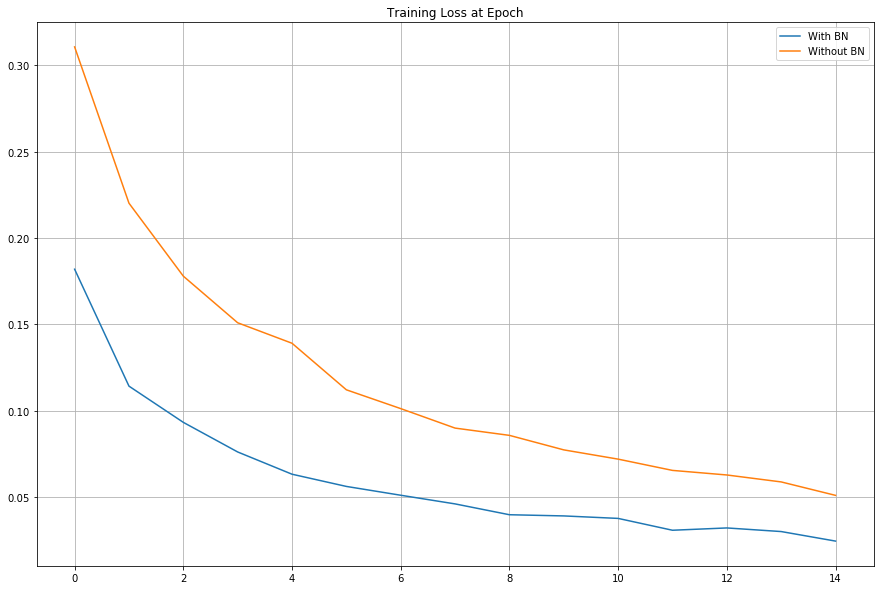

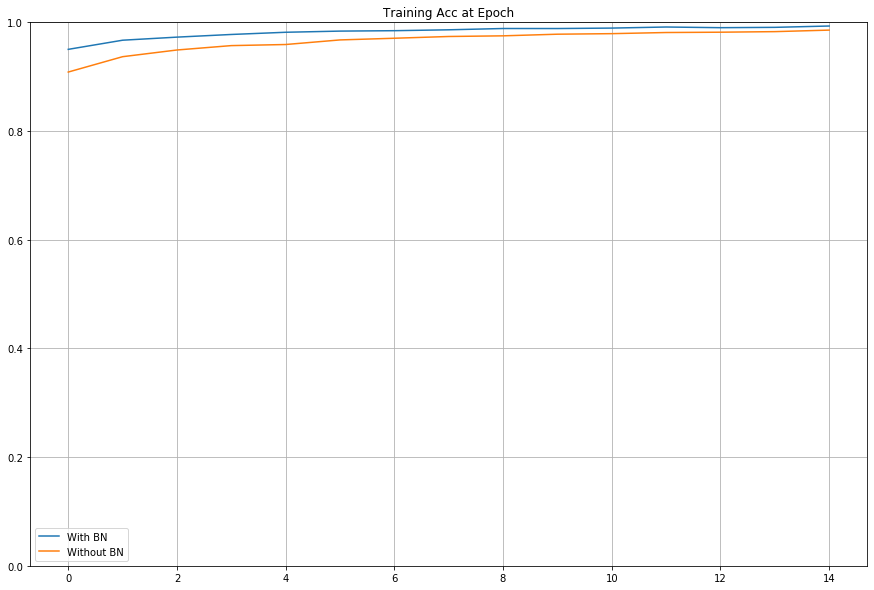

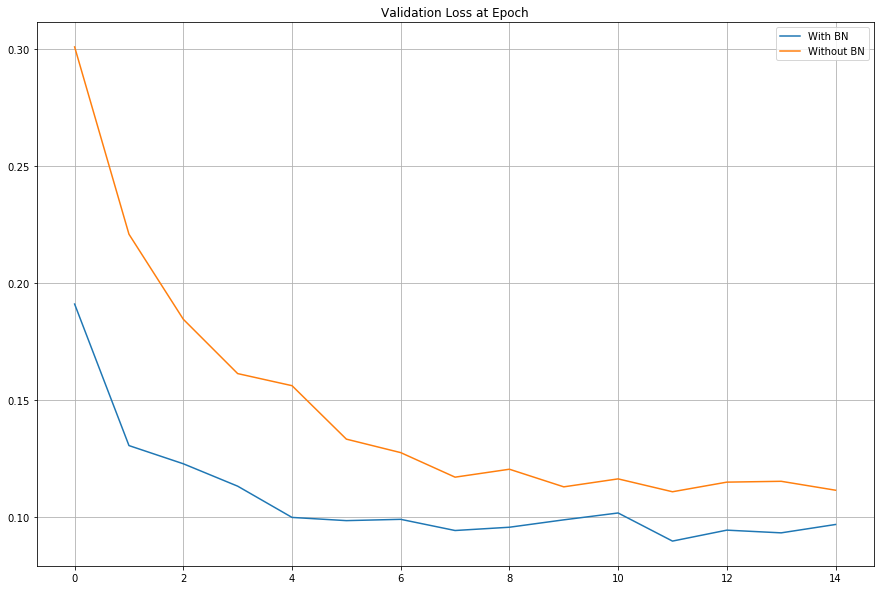

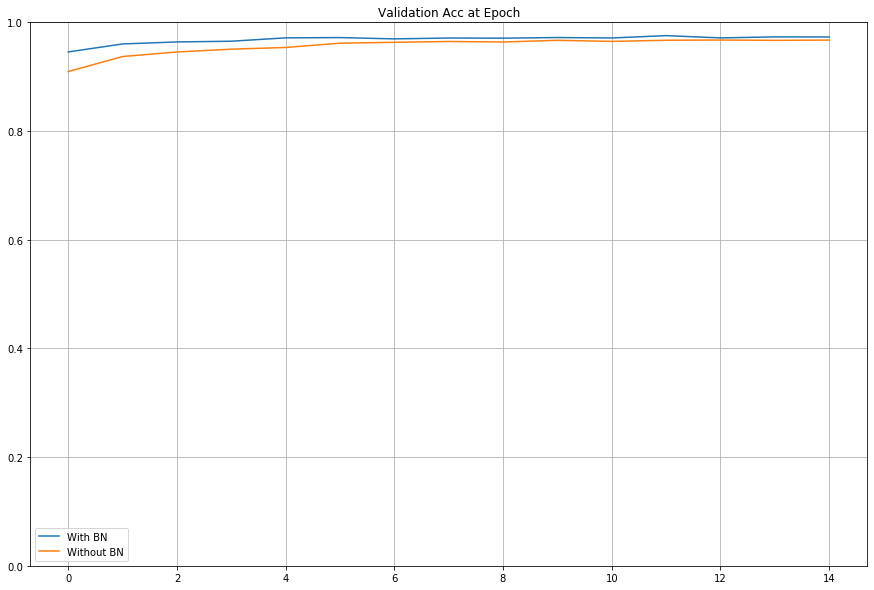

In [11]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')